In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [66]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv', na_values = "NA")
train.columns = train.columns.str.lower()
train.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [67]:
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv', na_values = "NA")
test.columns = test.columns.str.lower()
test.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [68]:
#I replaced all False values with 0 and True values with 1
train = train.replace({True: 1, False: 0})

**Per Kaggle:**

- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension.

# Exploratory Data Analysis -EDA

In [69]:
train.describe()

,cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8492 non-null   object 
 2   cryosleep     8476 non-null   float64
 3   cabin         8494 non-null   object 
 4   destination   8511 non-null   object 
 5   age           8514 non-null   float64
 6   vip           8490 non-null   float64
 7   roomservice   8512 non-null   float64
 8   foodcourt     8510 non-null   float64
 9   shoppingmall  8485 non-null   float64
 10  spa           8510 non-null   float64
 11  vrdeck        8505 non-null   float64
 12  name          8493 non-null   object 
 13  transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [71]:
#looking for unique values
unique = train.nunique()
unique

passengerid     8693
homeplanet         3
cryosleep          2
cabin           6560
destination        3
age               80
vip                2
roomservice     1273
foodcourt       1507
shoppingmall    1115
spa             1327
vrdeck          1306
name            8473
transported        2
dtype: int64

In [72]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications = train.duplicated().sum()
duplications

0

Text(0.5, 0, 'Transported by Homeplanet')

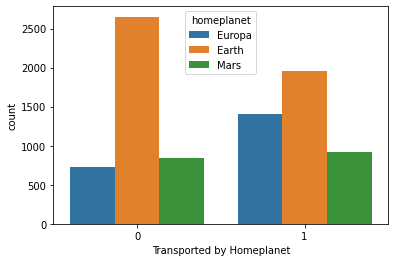

In [73]:
sns.countplot(data=train, x ='transported', hue = 'homeplanet')
plt.xlabel('Transported by Homeplanet' )

Text(0.5, 0, 'Transported Cryosleep Passengers')

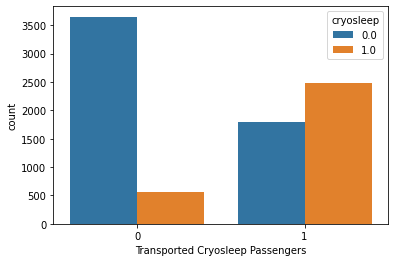

In [74]:
sns.countplot(data=train, x ='transported', hue = 'cryosleep')
plt.xlabel('Transported Cryosleep Passengers' )

Text(0.5, 0, 'VIP Passengers Transported')

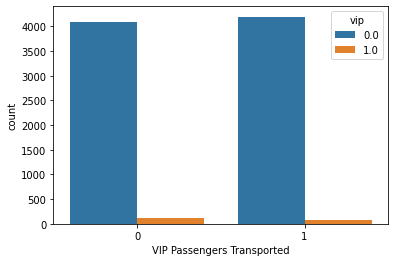

In [75]:
sns.countplot(data=train, x ='transported', hue = 'vip')
plt.xlabel('VIP Passengers Transported' )

Text(0.5, 0, 'Transported by Destination')

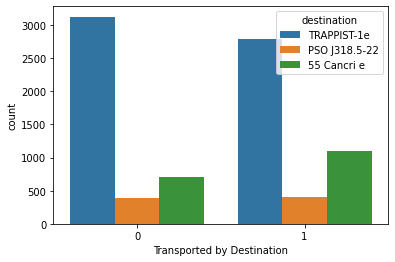

In [76]:
sns.countplot(data=train, x ='transported', hue = 'destination')
plt.xlabel('Transported by Destination' )

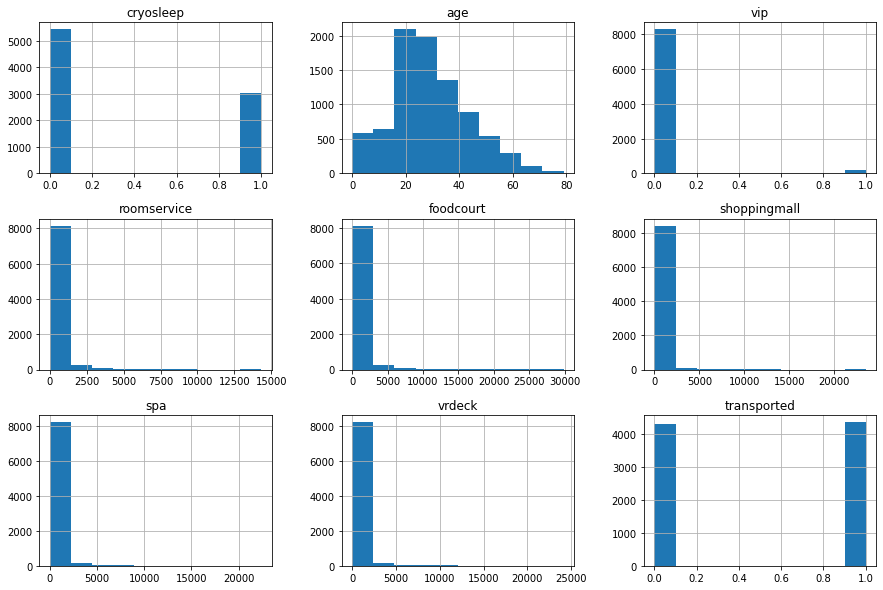

In [77]:
train.hist(figsize=(15,10))
plt.show()

From the above quick analysis, it appears that being VIP did not affect the success rate of the transportation. There was a positive affect of cryosleep and being from Europa on being successfully transported. I will calculate a correlation matrix after the missing data is filled in to see if there are other correlations.

## Correlation

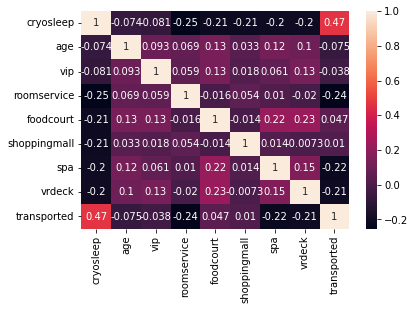

In [78]:
#This is a heatmap of the above information that makes it easier to see the features
#that correlate with each other (if any).
sns.heatmap(train.corr(), annot=True)
plt.show()

In [79]:
#Homeplanet was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['homeplanet'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

Earth    -0.169019
Europa    0.176916
Mars      0.019544
dtype: float64

This shows that being from Earth has a strong negative correlation to being transported successfully whereas the other 2 locations have a slightly positive correlation.

In [80]:
#Groups were not included in the above correlation as it is a string. I have seperated it 
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['destination'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

55 Cancri e      0.108722
PSO J318.5-22    0.000092
TRAPPIST-1e     -0.094700
dtype: float64

This shows that the destination of TRAPPIST has a negative correlation to being successfully transported as compared to the other two destinations.

### Group Size

In [81]:
#split the passengerid so we can establish groups (who is travelling with who).  
#This dataset does not distinguish between families or friend groups
train[['passengerid_1','passengerid_2']] = train['passengerid'].str.split('_', 2, expand=True)

In [82]:
#Groups was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['passengerid_2'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

01   -0.087695
02    0.048582
03    0.060768
04    0.029559
05    0.010575
06    0.008031
07   -0.000529
08   -0.003257
dtype: float64

<AxesSubplot:xlabel='passengerid_2', ylabel='transported'>

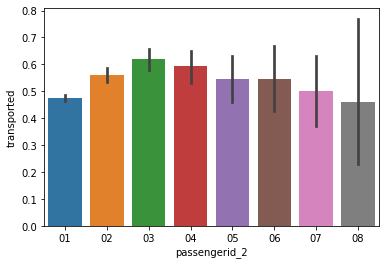

In [83]:
#Let's see if family size affects survival rates

sns.barplot(x = 'passengerid_2', y = 'transported', data = train)

<AxesSubplot:title={'center':'Successful Transportation by Group Size'}, xlabel='passengerid_2'>

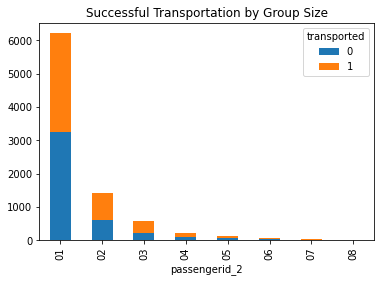

In [84]:
pd.crosstab(train['passengerid_2'], train['transported']).plot(kind='bar', stacked=True, title="Successful Transportation by Group Size")

It appears that if you travelled in a group between the 2 and 6 people, you had a positive correlation of correctly reaching your destination.

# Data Engineering

I will use SimpleImputer to fill in missing values. I will use 'most frequent' value for categorical and 'mean' for numerical.

In [85]:
train.isna().sum()

passengerid        0
homeplanet       201
cryosleep        217
cabin            199
destination      182
age              179
vip              203
roomservice      181
foodcourt        183
shoppingmall     208
spa              183
vrdeck           188
name             200
transported        0
passengerid_1      0
passengerid_2      0
dtype: int64

In [86]:
imputer = SimpleImputer(strategy='mean')

def imputer_numerical(df):
    (df).cryosleep = imputer.fit_transform((df)['cryosleep'].values.reshape(-1,1))[:,0]
    (df).age = imputer.fit_transform((df)['age'].values.reshape(-1,1))[:,0]
    (df).vip = imputer.fit_transform((df)['vip'].values.reshape(-1,1))[:,0]
    (df).roomservice = imputer.fit_transform((df)['roomservice'].values.reshape(-1,1))[:,0]
    (df).foodcourt = imputer.fit_transform((df)['foodcourt'].values.reshape(-1,1))[:,0]
    (df).shoppingmall = imputer.fit_transform((df)['shoppingmall'].values.reshape(-1,1))[:,0]
    (df).spa = imputer.fit_transform((df)['spa'].values.reshape(-1,1))[:,0]
    (df).vrdeck = imputer.fit_transform((df)['vrdeck'].values.reshape(-1,1))[:,0]

In [87]:
imputer_numerical(train)

In [88]:
imputer_cat = SimpleImputer(strategy='most_frequent')

def imputer_categorical(df):
    (df).homeplanet = imputer_cat.fit_transform((df)['homeplanet'].values.reshape(-1,1))[:,0]
    (df).destination = imputer_cat.fit_transform((df)['destination'].values.reshape(-1,1))[:,0]

In [89]:
imputer_categorical(train)

In [90]:
train.isna().sum()

passengerid        0
homeplanet         0
cryosleep          0
cabin            199
destination        0
age                0
vip                0
roomservice        0
foodcourt          0
shoppingmall       0
spa                0
vrdeck             0
name             200
transported        0
passengerid_1      0
passengerid_2      0
dtype: int64

I will drop the cabin column as we can't impute the missing numbers. It could be possible to group with families but I believe at this point in time, it is too much work for the benefit I would get (if any).

I will also drop names from the dataset.

In [91]:
train = train.drop(['cabin','name'], axis = 1)

In [92]:
#change the values in the 'fare' column to integers for ease of calculations
train['passengerid_1']=train['passengerid_1'].astype(int)
train['passengerid_2']=train['passengerid_2'].astype(int)

## Factorizing Features

In [93]:
#I will factorise homeplanet and destination
train['homeplanet_f'] = pd.factorize(train['homeplanet'])[0]
train['destination_f'] = pd.factorize(train['destination'])[0]

# Define X and y

In [94]:
#drop the column "transported" from file as we are creating a ML to predict this column
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X_train = train.drop(['passengerid','homeplanet','destination','transported'], axis = 1)
y_train = train['transported']

# Random Forest Classification

In [95]:
X_train.shape, y_train.shape

((8693, 12), (8693,))

In [96]:
rfc = RandomForestClassifier(n_estimators=120, max_depth=12) 
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=120)

In [97]:
y_pred = rfc.predict(X_train)
y_pred.shape

(8693,)

In [98]:
round(rfc.score(X_train, y_train),3)

0.875

In [99]:
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 0.15338
Feature: 1, Score: 0.07225
Feature: 2, Score: 0.00632
Feature: 3, Score: 0.13289
Feature: 4, Score: 0.10180
Feature: 5, Score: 0.07675
Feature: 6, Score: 0.13132
Feature: 7, Score: 0.13320
Feature: 8, Score: 0.08262
Feature: 9, Score: 0.02031
Feature: 10, Score: 0.07105
Feature: 11, Score: 0.01811


In [100]:
# Calculate the accuracy
accuracy = rfc.score(X_train,y_train)

In [101]:
print(f"""The Random Forest Model has achieved an: \n 
accuracy = {round(accuracy,2)}\n
precision = {round(precision_score(y_train,y_pred),2)} \n 
recall = {round(recall_score(y_train,y_pred),2)}\n
f1 = {round(f1_score(y_train,y_pred),2)}""")

The Random Forest Model has achieved an: 
 
accuracy = 0.88

precision = 0.86 
 
recall = 0.9

f1 = 0.88


# Cross-Validation RFC

In [102]:
cross_accuracy_logRFC = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train
                                        ,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_RFC = np.round_(cross_accuracy_logRFC, 2)
CAL_RFC

array([0.65, 0.73, 0.79, 0.81, 0.69])

# Test Data

In [103]:
#I replaced all False values with 0 and True values with 1
test = test.replace({True: 1, False: 0})

In [104]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications_test = test.duplicated().sum()
duplications_test

0

In [105]:
test.isna().sum()

passengerid       0
homeplanet       87
cryosleep        93
cabin           100
destination      92
age              91
vip              93
roomservice      82
foodcourt       106
shoppingmall     98
spa             101
vrdeck           80
name             94
dtype: int64

In [106]:
imputer_numerical(test)
imputer_categorical(test)

In [107]:
test.isna().sum()

passengerid       0
homeplanet        0
cryosleep         0
cabin           100
destination       0
age               0
vip               0
roomservice       0
foodcourt         0
shoppingmall      0
spa               0
vrdeck            0
name             94
dtype: int64

In [108]:
#split the passengerid so we can establish groups (who is travelling with who).  
#This dataset does not distinguish between families or friend groups
test[['passengerid_1','passengerid_2']] = test['passengerid'].str.split('_', 2, expand=True)

In [109]:
#change the values in the 'fare' column to integers for ease of calculations
test['passengerid_1']=test['passengerid_1'].astype(int)
test['passengerid_2']=test['passengerid_2'].astype(int)

In [110]:
test = test.drop(['cabin','name'], axis = 1)

In [111]:
#I will factorise homeplanet and destination
test['homeplanet_f'] = pd.factorize(test['homeplanet'])[0]
test['destination_f'] = pd.factorize(test['destination'])[0]

In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    4277 non-null   object 
 1   homeplanet     4277 non-null   object 
 2   cryosleep      4277 non-null   float64
 3   destination    4277 non-null   object 
 4   age            4277 non-null   float64
 5   vip            4277 non-null   float64
 6   roomservice    4277 non-null   float64
 7   foodcourt      4277 non-null   float64
 8   shoppingmall   4277 non-null   float64
 9   spa            4277 non-null   float64
 10  vrdeck         4277 non-null   float64
 11  passengerid_1  4277 non-null   int64  
 12  passengerid_2  4277 non-null   int64  
 13  homeplanet_f   4277 non-null   int64  
 14  destination_f  4277 non-null   int64  
dtypes: float64(8), int64(4), object(3)
memory usage: 501.3+ KB


In [113]:
#drop the column "transported" from file as we are creating a ML to predict this column
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X_test = test.drop(['passengerid','homeplanet','destination'], axis = 1)

In [114]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cryosleep      4277 non-null   float64
 1   age            4277 non-null   float64
 2   vip            4277 non-null   float64
 3   roomservice    4277 non-null   float64
 4   foodcourt      4277 non-null   float64
 5   shoppingmall   4277 non-null   float64
 6   spa            4277 non-null   float64
 7   vrdeck         4277 non-null   float64
 8   passengerid_1  4277 non-null   int64  
 9   passengerid_2  4277 non-null   int64  
 10  homeplanet_f   4277 non-null   int64  
 11  destination_f  4277 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 401.1 KB


In [115]:
#predictions on real data
y_pred = rfc.predict(X_test)

In [116]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [117]:
#I replaced all False values with 0 and True values with 1
y_pred_bool = y_pred.astype(bool)

In [118]:
y_pred_bool

array([ True, False,  True, ...,  True,  True,  True])

In [119]:
output = pd.DataFrame({'PassengerId': test.passengerid, 'transported': y_pred_bool})
output.to_csv('submission_Nov2_v2_bool_rfc.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
